(variational_api_quickstart)=

# Introduction to Variational Inference with PyMC

The most common strategy for computing posterior quantities of Bayesian models is via sampling,  particularly Markov chain Monte Carlo (MCMC) algorithms. While sampling algorithms and associated computing have continually improved in performance and efficiency, MCMC methods still scale poorly with data size, and become prohibitive for more than a few thousand observations. A more scalable alternative to sampling is variational inference (VI), which re-frames the problem of computing the posterior distribution as an optimization problem. 

In PyMC, the variational inference API is focused on approximating posterior distributions through a suite of modern algorithms. Common use cases to which this module can be applied include:

* Sampling from model posterior and computing arbitrary expressions
* Conducting Monte Carlo approximation of expectation, variance, and other statistics
* Removing symbolic dependence on PyMC random nodes and evaluate expressions (using `eval`)
* Providing a bridge to arbitrary PyTensor code

:::{post} Jan 13, 2023 
:tags: variational inference
:category: intermediate, how-to
:author: Maxim Kochurov, Chris Fonnesbeck
:::

In [83]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns

np.random.seed(42)

w = np.array([0.2, 0.8])
mu = np.array([-0.3, 0.5])
sd = np.array([0.1, 0.1])

with pm.Model() as model:

    mu = pm.Normal("mu", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    x = pm.Normal("x", mu=mu, sigma=sigma, observed=gamma_data)
    x2 = x**2
    sin_x = pm.math.sin(x)


    svgd_approx = pm.fit(
        300,
        method="svgd",
        inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01),
    )

Fitting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01

In [88]:
with pm.Model() as gamma_model:

    alpha = pm.Exponential("alpha", 0.1)
    beta = pm.Exponential("beta", 0.1)
    
    x = pm.Gamma("y", alpha, beta, observed=gamma_data)
    x2 = x**2
    sin_x = pm.math.sin(x)


    svgd_approx_gamma = pm.fit(
        300,
        method="svgd",
        inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01),
    )    


    

Fitting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01

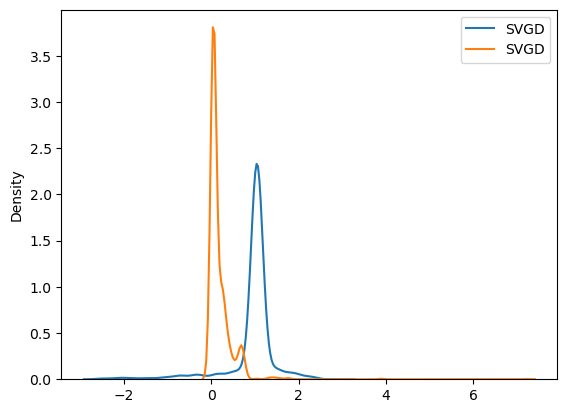

In [91]:
sns.kdeplot(svgd_approx.sample(2000).posterior["mu"].values.flatten(), label="SVGD")
sns.kdeplot(svgd_approx_gamma.sample(2000).posterior["alpha"].values.flatten(), label="SVGD")

#plt.gca().axvline(mu, c='k', ls='dotted')
plt.legend();

# so I would need a custum distribution of my likelibood/probability as a function of N and other params...

-----

In [10]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import seaborn as sns

np.random.seed(42)

## Distributional Approximations

There are severa methods in statistics that use a simpler distribution to approximate a more complex distribution. Perhaps the best-known example is the **Laplace (normal) approximation**. This involves constructing a Taylor series of the target posterior, but retaining only the terms of quadratic order and using those to construct a multivariate normal approximation.

Similarly, variational inference is another distributional approximation method where, rather than leveraging a Taylor series, some class of approximating distribution is chosen and its parameters are optimized such that the resulting distribution is as close as possible to the posterior. In essence, VI is a deterministic approximation that places bounds on the density of interest, then uses opimization to choose from that bounded set.

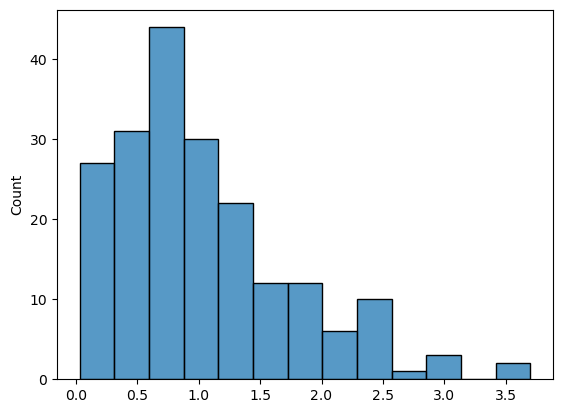

In [78]:
gamma_data = np.random.gamma(2, 0.5, size=200)
sns.histplot(gamma_data);

In [12]:
with pm.Model() as gamma_model:
    alpha = pm.Exponential("alpha", 0.1)
    beta = pm.Exponential("beta", 0.1)

    y = pm.Gamma("y", alpha, beta, observed=gamma_data)

In [13]:
with gamma_model:
    # mean_field = pm.fit()
    mean_field = pm.fit(obj_optimizer=pm.adagrad_window(learning_rate=1e-2))

Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━  80% 0:00:01 Average Loss = 169.87

Finished [100%]: Average Loss = 169.87


In [14]:
with gamma_model:
    trace = pm.sample()

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [15]:
mean_field

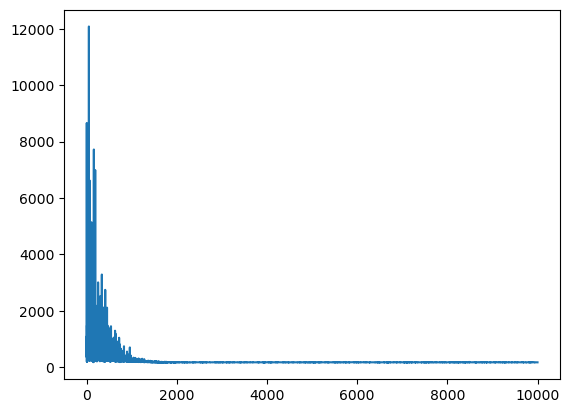

In [16]:
plt.plot(mean_field.hist);

In [17]:
approx_sample = mean_field.sample(1000)

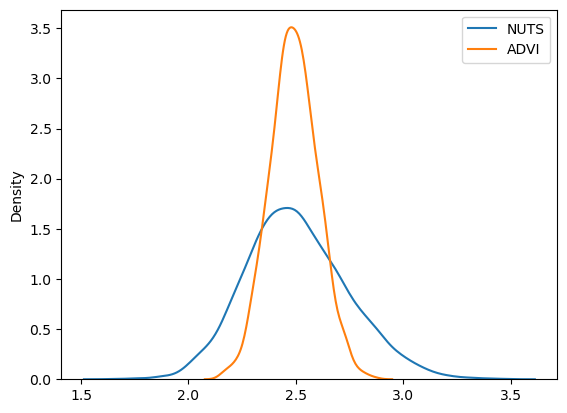

In [18]:
sns.kdeplot(trace.posterior["alpha"].values.flatten(), label="NUTS")
sns.kdeplot(approx_sample.posterior["alpha"].values.flatten(), label="ADVI")
plt.legend();

## Basic setup

We do not need complex models to play with the VI API; let's begin with a simple mixture model:

In [19]:
w = np.array([0.2, 0.8])
mu = np.array([-0.3, 0.5])
sd = np.array([0.1, 0.1])

In [20]:
with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    x2 = x**2
    sin_x = pm.math.sin(x)

We can't compute analytical expectations for this model. However, we can obtain an approximation using Markov chain Monte Carlo methods; let's use NUTS first. 

To allow samples of the expressions to be saved, we need to wrap them in `Deterministic` objects:

In [21]:
with model:
    pm.Deterministic("x2", x2)
    pm.Deterministic("sin_x", sin_x)

In [22]:
with model:
    trace = pm.sample(5000)

Sampling 4 chains, 1,014 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:01

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1 seconds.
There were 1014 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


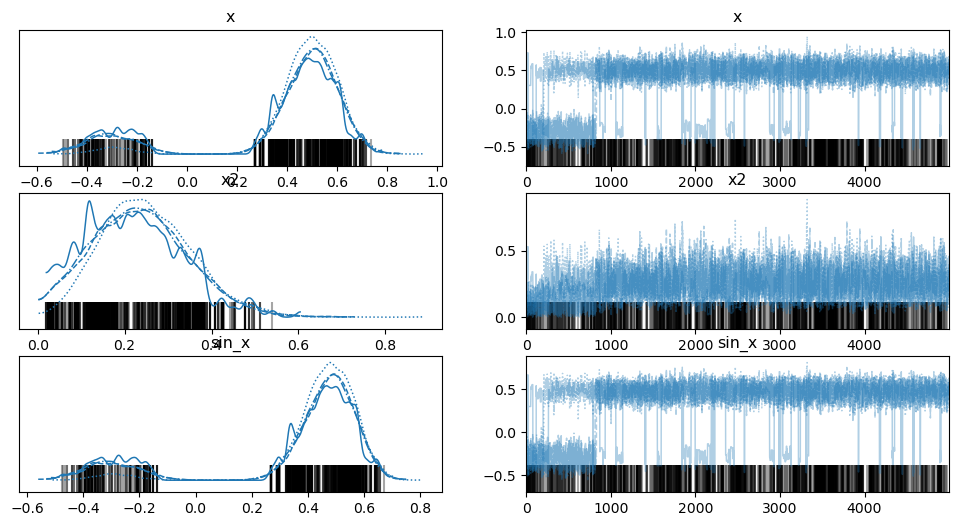

In [23]:
az.plot_trace(trace);

Above are traces for $x^2$ and $sin(x)$. We can see there is clear multi-modality in this model. One drawback, is that you need to know in advance what exactly you want to see in trace and wrap it with `Deterministic`.

The VI API takes an alternate approach: You obtain inference from model, then calculate expressions based on this model afterwards. 

Let's use the same model:

In [24]:
with pm.Model() as model:
    x = pm.NormalMixture("x", w=w, mu=mu, sigma=sd)
    x2 = x**2
    sin_x = pm.math.sin(x)

Here we will use automatic differentiation variational inference (ADVI).

In [25]:
with model:
    mean_field = pm.fit(method="advi")

Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━  67% 0:00:01 Average Loss = 2.2949

Finished [100%]: Average Loss = 2.3564


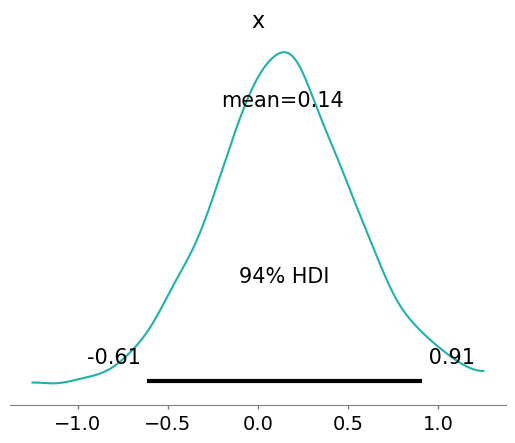

In [26]:
az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");

Notice that ADVI has failed to approximate the multimodal distribution, since it uses a Gaussian distribution that has a single mode.

## Checking convergence

Let's use the default arguments for `CheckParametersConvergence` as they seem to be reasonable.

In [27]:
from pymc.variational.callbacks import CheckParametersConvergence

with model:
    mean_field = pm.fit(method="advi", callbacks=[CheckParametersConvergence()])

Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━  88% 0:00:01 Average Loss = 2.329

Finished [100%]: Average Loss = 2.027


We can access inference history via `.hist` attribute.

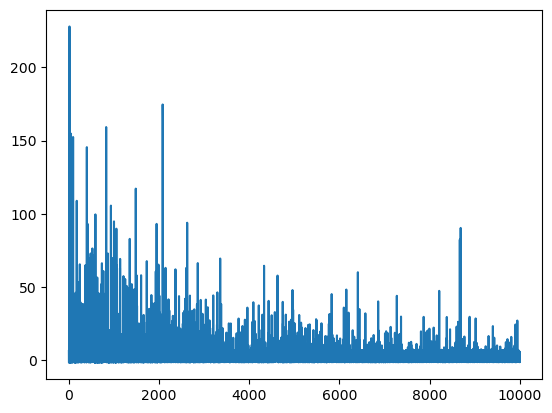

In [28]:
plt.plot(mean_field.hist);

This is not a good convergence plot, despite the fact that we ran many iterations. The reason is that the mean of the ADVI approximation is close to zero, and therefore taking the relative difference (the default method) is unstable for checking convergence.

In [29]:
with model:
    mean_field = pm.fit(
        method="advi", callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")]
    )

Fitting: ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━  30% 0:00:01 Average Loss = 3.7841

Convergence achieved at 5400
Interrupted at 5,399 [53%]: Average Loss = 4.5745


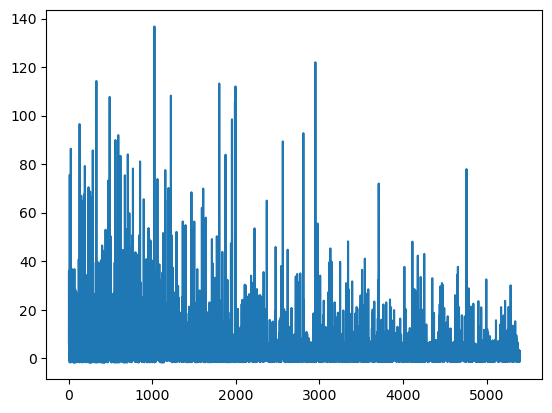

In [30]:
plt.plot(mean_field.hist);

That's much better! We've reached convergence after less than 5000 iterations.

## Tracking parameters

Another useful callback allows users to track parameters. It allows for the tracking of arbitrary statistics during inference, though it can be memory-hungry. Using the `fit` function, we do not have direct access to the approximation before inference. However, tracking parameters requires access to the approximation. We can get around this constraint by using the object-oriented (OO) API for inference.

In [31]:
with model:
    advi = pm.ADVI()

In [32]:
advi.approx

Different approximations have different hyperparameters. In mean-field ADVI, we have $\rho$ and $\mu$ (inspired by [Bayes by BackProp](https://arxiv.org/abs/1505.05424)).

In [33]:
advi.approx.shared_params

{'mu': mu, 'rho': rho}

There are convenient shortcuts to relevant statistics associated with the approximation. This can be useful, for example, when specifying a mass matrix for NUTS sampling:

In [34]:
advi.approx.mean.eval(), advi.approx.std.eval()

(array([0.34]), array([0.69314718]))

We can roll these statistics into the `Tracker` callback.

In [35]:
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval,  # callable that returns std
)

Now, calling `advi.fit` will record the mean and standard deviation of the approximation as it runs.

In [36]:
approx = advi.fit(20000, callbacks=[tracker])

Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺  98% 0:00:01 Average Loss = 2.2932

Finished [100%]: Average Loss = 2.1766


We can now plot both the evidence lower bound and parameter traces:

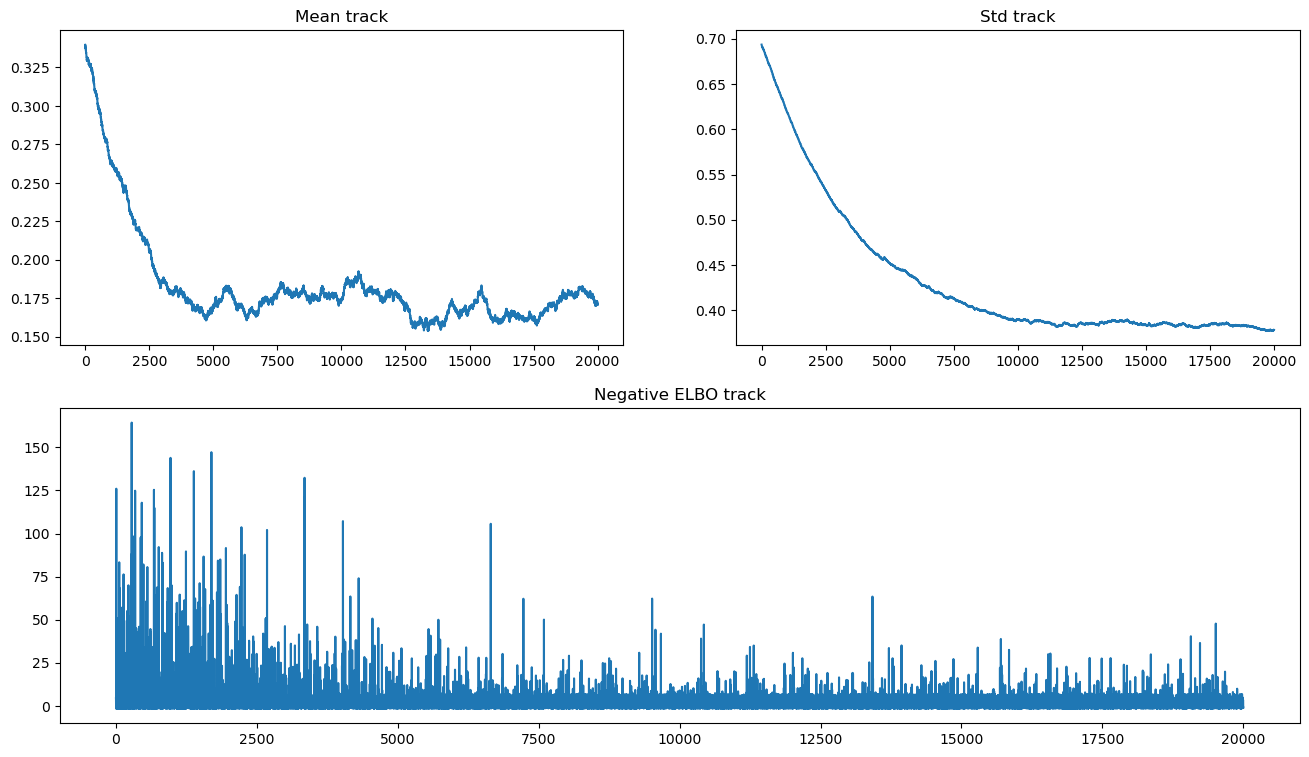

In [37]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track");

Notice that there are convergence issues with the mean, and that lack of convergence does not seem to change the ELBO trajectory significantly. As we are using the OO API, we can run the approximation longer until convergence is achieved.

In [38]:
advi.refine(100_000)

Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:00:01 Average Loss = 2.0037

Finished [100%]: Average Loss = 2.1594


Let's take a look:

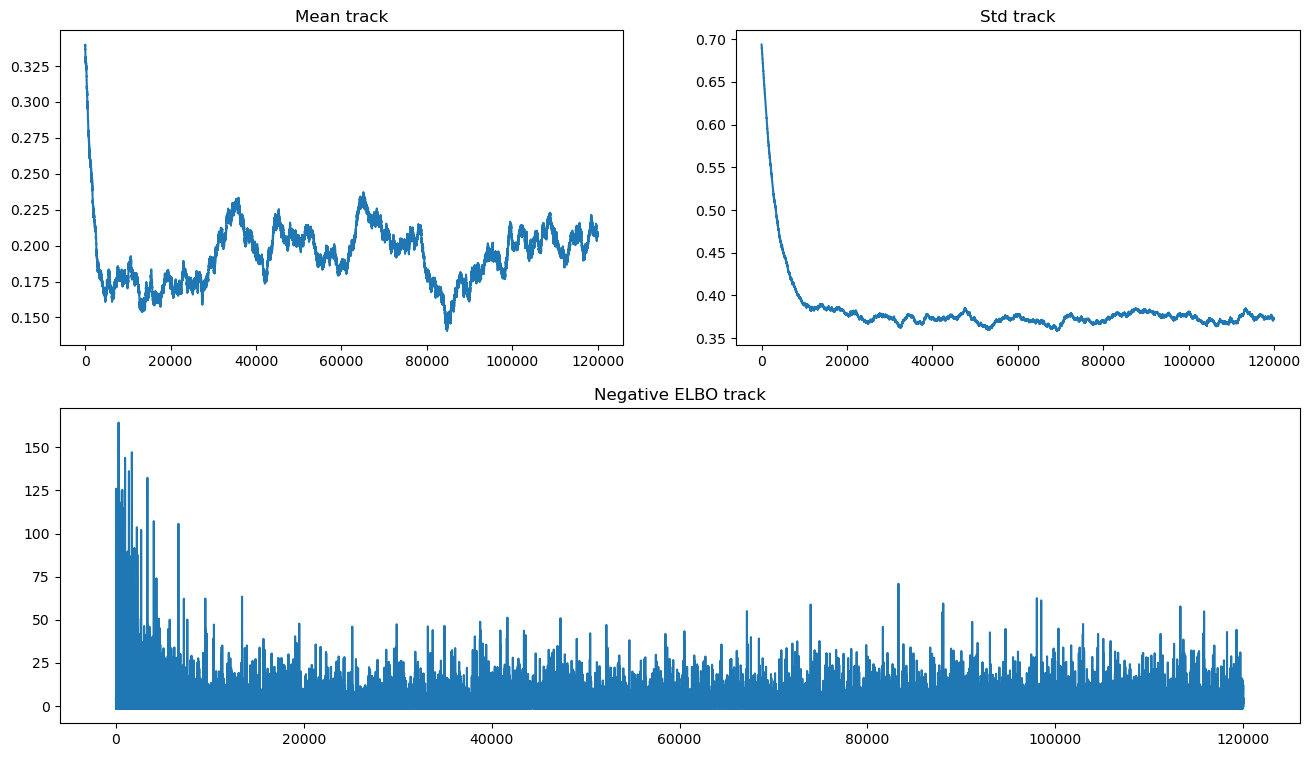

In [39]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker["mean"])
mu_ax.set_title("Mean track")
std_ax.plot(tracker["std"])
std_ax.set_title("Std track")
hist_ax.plot(advi.hist)
hist_ax.set_title("Negative ELBO track");

We still see evidence for lack of convergence, as the mean has devolved into a random walk. This could be the result of choosing a poor algorithm for inference. At any rate, it is unstable and can produce very different results even using different random seeds.

Let's compare results with the NUTS output:

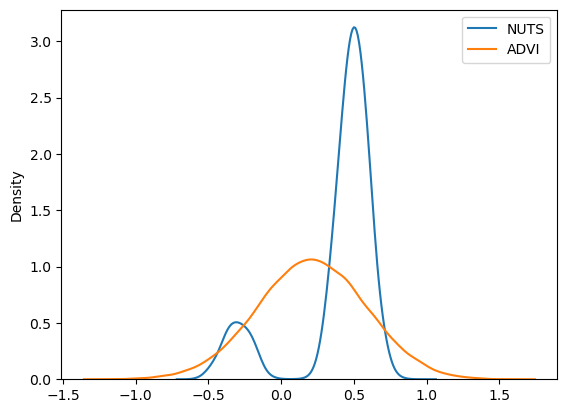

In [40]:
sns.kdeplot(trace.posterior["x"].values.flatten(), label="NUTS")
sns.kdeplot(approx.sample(20000).posterior["x"].values.flatten(), label="ADVI")
plt.legend();

Again, we see that ADVI is not able to cope with multimodality; we can instead use SVGD, which generates an approximation based on a large number of particles.

In [41]:
with model:
    svgd_approx = pm.fit(
        300,
        method="svgd",
        inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01),
    )

Fitting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01

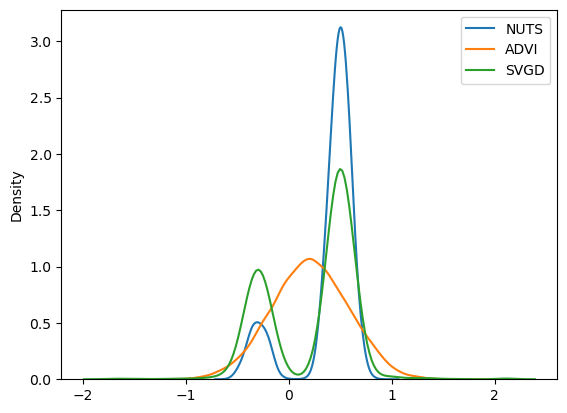

In [42]:
sns.kdeplot(trace.posterior["x"].values.flatten(), label="NUTS")
sns.kdeplot(approx.sample(10000).posterior["x"].values.flatten(), label="ADVI")
sns.kdeplot(svgd_approx.sample(2000).posterior["x"].values.flatten(), label="SVGD")
plt.legend();

That did the trick, as we now have a multimodal approximation using SVGD. 

With this, it is possible to calculate arbitrary functions of the parameters with this variational approximation. For example we can calculate $x^2$ and $sin(x)$, as with the NUTS model.

In [43]:
# recall x ~ NormalMixture
a = x**2
b = pm.math.sin(x)

To evaluate these expressions with the approximation, we need `approx.sample_node`.

In [44]:
a_sample = svgd_approx.sample_node(a)
a_sample.eval()

array(0.26796925)

In [45]:
a_sample.eval()

array(0.26796925)

In [46]:
a_sample.eval()

array(0.26796925)

Every call yields a different value from the same node. This is because it is **stochastic**. 

By applying replacements, we are now free of the dependence on the PyMC model; instead, we now depend on the approximation. Changing it will change the distribution for stochastic nodes:

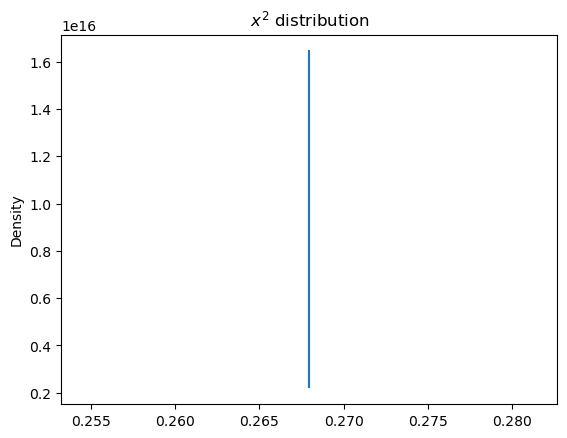

In [47]:
sns.kdeplot(np.array([a_sample.eval() for _ in range(2000)]))
plt.title("$x^2$ distribution");

There is a more convenient way to get lots of samples at once: `sample_node`

In [48]:
a_samples = svgd_approx.sample_node(a, size=1000)

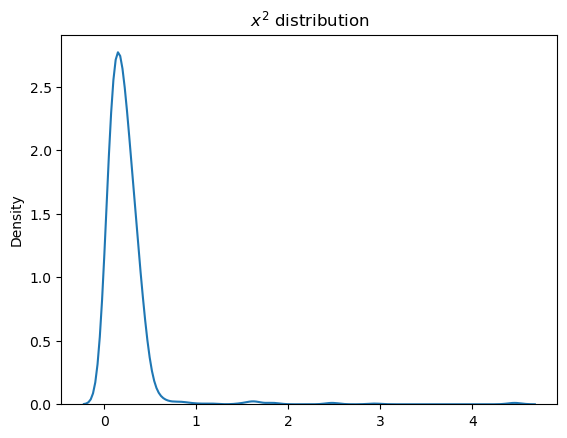

In [49]:
sns.kdeplot(a_samples.eval())
plt.title("$x^2$ distribution");

The `sample_node` function includes an additional dimension, so taking expectations or calculating variance is specified by `axis=0`.

In [50]:
a_samples.var(0).eval()  # variance

array(0.08554904)

In [51]:
a_samples.mean(0).eval()  # mean

array(0.22969851)

A symbolic sample size can also be specified:

In [52]:
import pytensor.tensor as pt

i = pt.iscalar("i")
i.tag.test_value = 1
a_samples_i = svgd_approx.sample_node(a, size=i)

In [53]:
a_samples_i.eval({i: 100}).shape

(100,)

In [54]:
a_samples_i.eval({i: 10000}).shape

(10000,)

Unfortunately the size must be a scalar value.

## Multilabel logistic regression

Let's illustrate the use of `Tracker` with the famous Iris dataset. We'll attempy multi-label classification and compute the expected accuracy score as a diagnostic.

In [56]:
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

![](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2015/04/iris_petal_sepal.png)

A relatively simple model will be sufficient here because the classes are roughly linearly separable; we are going to fit multinomial logistic regression.

In [57]:
Xt = pytensor.shared(X_train)
yt = pytensor.shared(y_train)

with pm.Model() as iris_model:
    # Coefficients for features
    β = pm.Normal("β", 0, sigma=1e2, shape=(4, 3))
    # Transoform to unit interval
    a = pm.Normal("a", sigma=1e4, shape=(3,))
    p = pt.special.softmax(Xt.dot(β) + a, axis=-1)

    observed = pm.Categorical("obs", p=p, observed=yt)

### Applying replacements in practice
PyMC models have symbolic inputs for latent variables. To evaluate an expression that requires knowledge of latent variables, one needs to provide fixed values. We can use values approximated by VI for this purpose. The function `sample_node` removes the symbolic dependencies. 

`sample_node` will use the whole distribution at each step, so we will use it here. We can apply more replacements in single function call using the `more_replacements` keyword argument in both replacement functions.

> **HINT:** You can use `more_replacements` argument when calling `fit` too:
>   * `pm.fit(more_replacements={full_data: minibatch_data})`
>   * `inference.fit(more_replacements={full_data: minibatch_data})`

In [58]:
with iris_model:
    # We'll use SVGD
    inference = pm.SVGD(n_particles=500, jitter=1)

    # Local reference to approximation
    approx = inference.approx

    # Here we need `more_replacements` to change train_set to test_set
    test_probs = approx.sample_node(p, more_replacements={Xt: X_test}, size=100)

    # For train set no more replacements needed
    train_probs = approx.sample_node(p)

By applying the code above, we now have 100 sampled probabilities (default number for `sample_node` is `None`) for each observation.

Next we create symbolic expressions for sampled accuracy scores:

In [59]:
test_ok = pt.eq(test_probs.argmax(-1), y_test)
train_ok = pt.eq(train_probs.argmax(-1), y_train)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

Tracker expects callables so we can pass `.eval` method of PyTensor node that is function itself. 

Calls to this function are cached so they can be reused.

In [60]:
eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval, train_accuracy=train_accuracy.eval
)

In [61]:
inference.fit(100, callbacks=[eval_tracker]);

Fitting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:00:01

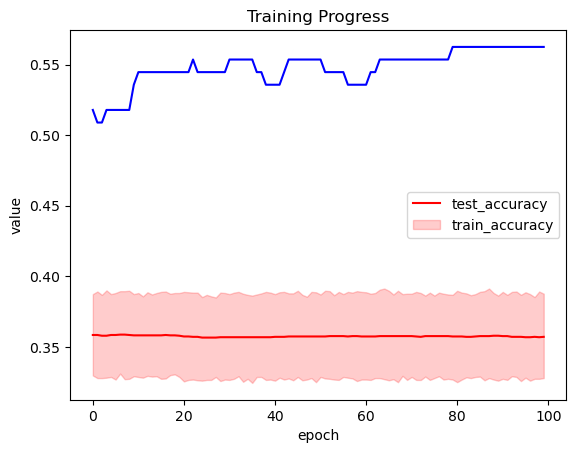

In [62]:
_, ax = plt.subplots(1, 1)
df = pd.DataFrame(eval_tracker["test_accuracy"]).T.melt()
sns.lineplot(x="variable", y="value", data=df, color="red", ax=ax)
ax.plot(eval_tracker["train_accuracy"], color="blue")
ax.set_xlabel("epoch")
plt.legend(["test_accuracy", "train_accuracy"])
plt.title("Training Progress");

Training does not seem to be working here. Let's use a different optimizer and boost the learning rate.

In [63]:
inference.fit(400, obj_optimizer=pm.adamax(learning_rate=0.1), callbacks=[eval_tracker]);

Fitting ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 100% 0:00:01

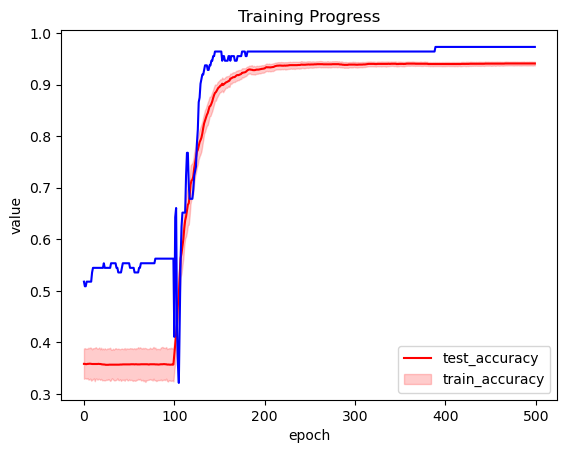

In [64]:
_, ax = plt.subplots(1, 1)
df = pd.DataFrame(np.asarray(eval_tracker["test_accuracy"])).T.melt()
sns.lineplot(x="variable", y="value", data=df, color="red", ax=ax)
ax.plot(eval_tracker["train_accuracy"], color="blue")
ax.set_xlabel("epoch")
plt.legend(["test_accuracy", "train_accuracy"])
plt.title("Training Progress");

This is much better! 

So, `Tracker` allows us to monitor our approximation and choose good training schedule.

## Minibatches
When dealing with large datasets, using minibatch training can drastically speed up and improve approximation performance. Large datasets impose a hefty cost on the computation of gradients. 

There is a nice API in PyMC to handle these cases, which is available through the `pm.Minibatch` class. The minibatch is just a highly specialized PyTensor tensor.

To demonstrate, let's simulate a large quantity of data:

In [65]:
# Raw values
data = np.random.rand(40000, 100)
# Scaled values
data *= np.random.randint(1, 10, size=(100,))
# Shifted values
data += np.random.rand(100) * 10

For comparison, let's fit a model without minibatch processing:

In [66]:
with pm.Model() as model:
    mu = pm.Flat("mu", shape=(100,))
    sd = pm.HalfNormal("sd", shape=(100,))
    lik = pm.Normal("lik", mu, sigma=sd, observed=data)

Just for fun, let's create a custom special purpose callback to halt slow optimization. Here we define a callback that causes a hard stop when approximation runs too slowly:

In [67]:
def stop_after_10(approx, loss_history, i):
    if (i > 0) and (i % 10) == 0:
        raise StopIteration("I was slow, sorry")

In [68]:
with model:
    advifit = pm.fit(callbacks=[stop_after_10])

Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% 0:02:56 Average Loss = 3.7692e+08

I was slow, sorry
Interrupted at 9 [0%]: Average Loss = 5.6e+08


Inference is too slow, taking several seconds per iteration; fitting the approximation would have taken hours!

Now let's use minibatches. At every iteration, we will draw 500 random values:

> Remember to set `total_size` in observed

**total_size** is an important parameter that allows PyMC to infer the right way of rescaling densities. If it is not set, you are likely to get completely wrong results. For more information please refer to the comprehensive documentation of `pm.Minibatch`.

In [69]:
X = pm.Minibatch(data, batch_size=500)

with pm.Model() as model:
    mu = pm.Normal("mu", 0, sigma=1e5, shape=(100,))
    sd = pm.HalfNormal("sd", shape=(100,))
    likelihood = pm.Normal("likelihood", mu, sigma=sd, observed=X, total_size=data.shape)

In [70]:
with model:
    advifit = pm.fit()

Fitting: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:00:01 Average Loss = 1.5174e+05

Finished [100%]: Average Loss = 1.5126e+05


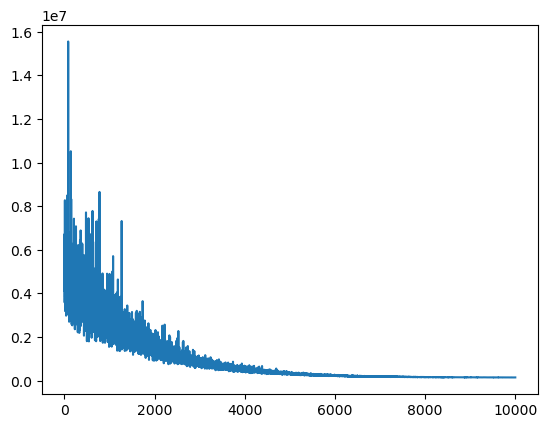

In [71]:
plt.plot(advifit.hist);

Minibatch inference is dramatically faster. Multidimensional minibatches may be needed for some corner cases where you do matrix factorization or model is very wide.

Here is the docstring for `Minibatch` to illustrate how it can be customized.

In [72]:
print(pm.Minibatch.__doc__)

Get random slices from variables from the leading dimension.

    Parameters
    ----------
    variable: TensorVariable
    variables: TensorVariable
    batch_size: int

    Examples
    --------
    >>> data1 = np.random.randn(100, 10)
    >>> data2 = np.random.randn(100, 20)
    >>> mdata1, mdata2 = Minibatch(data1, data2, batch_size=10)
    


## Authors

* Authored by Maxim Kochurov
* Updated by Chris Fonnesbeck ([pymc-examples#429](https://github.com/pymc-devs/pymc-examples/pull/497))

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

:::{include} ../page_footer.md
:::